### makemore: part 5

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
words[:8]

32033
15


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# sbuffle the words

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [40]:
class Linear: # modeled after torch.nn.Linear (in_features, out_features, bias=True, device=None, dtype=None) - we're omitting the last 2 paraneters
    # default device is CPU, dtype is float32
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # second part is the kaiming initialization discussed earlier
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d: # modeled after torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)
    def __init__(self, dim, eps=1e-5, momentum=0.1): # 

        # saving the values
        self.eps = eps
        self.momentum = momentum
        self.training = True # we use this because during training, we use the batch mean and variance, whereas during inference we use the running values
        
        # parameters (trained with backprop)
        
        # affine=True in torch.nn.BatchNorm1d means we're using a gain and bias or gamma and beta, which we are below:
        self.gamma = torch.ones(dim) # gain 
        self.beta = torch.zeros(dim) # bias
        
        # track_running_stats=True means we're keeping track of running mean and variance
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim) # running variance (std^2); we're using variance bc that's what used in the paper

    def __call__(self, x):
        # calculate the fwd pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance (this is the formula used in PyTorch)
        self.out = self.gamma * xhat + self.beta # self.out is used here to keep track of the stats to graph them later, but it's not present in PT
        # update the buffers
        if self.training:
            with torch.no_grad(): # tells PT to not keep track of the gradients, which makes it more efficient
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean 
                # this method of training used to update the buffer values is called exponential moving avg
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return[]

In [41]:
torch.manual_seed(42)

In [14]:
n_embd = 10 # dimentionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C  = torch.randn((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
]
with torch.no_grad():

    # this section is the first change we made, where we squashed the weights of the last layer
    # last layer: make less confident
    # layers[-1].weight += 0.1 # since the last layer is a batchnorm layer, we want to change the gamma, which is essentially the weight because it's multiplied by the output of the previous layer
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [16]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #     break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.3204
  10000/ 200000: 2.4029
  20000/ 200000: 2.2609
  30000/ 200000: 2.2126
  40000/ 200000: 2.4049
  50000/ 200000: 2.4264
  60000/ 200000: 2.6779
  70000/ 200000: 2.4182
  80000/ 200000: 2.1344
  90000/ 200000: 2.1335
 100000/ 200000: 1.8149
 110000/ 200000: 2.3402
 120000/ 200000: 2.0808
 130000/ 200000: 1.8054
 140000/ 200000: 2.6695
 150000/ 200000: 2.1113
 160000/ 200000: 2.2653
 170000/ 200000: 2.1328
 180000/ 200000: 2.1159
 190000/ 200000: 1.7268


In [22]:
len(lossi)

200000

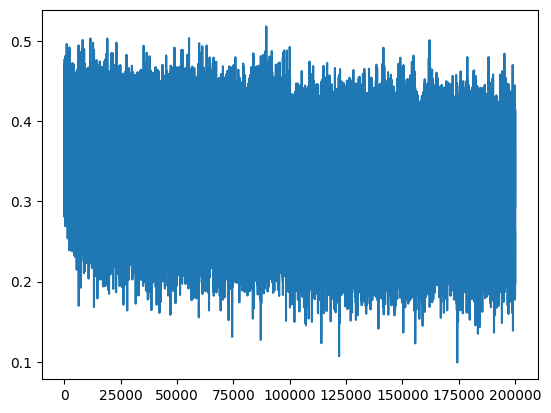

In [17]:
plt.plot(lossi)

The graph above doesn't give us much info, as each lossi alternates between increasing and decreasing for each iteration. A better way to view this would be to take the mean across every few consecutive elements and plot that. 

In [27]:
torch.tensor(lossi).view((-1, 1000)).mean(1) # allows us to plot the means of every 1000 elements

tensor([0.3786, 0.3721, 0.3690, 0.3657, 0.3620, 0.3603, 0.3585, 0.3544, 0.3580,
        0.3570, 0.3527, 0.3514, 0.3507, 0.3503, 0.3518, 0.3477, 0.3481, 0.3470,
        0.3475, 0.3475, 0.3437, 0.3429, 0.3480, 0.3434, 0.3446, 0.3439, 0.3438,
        0.3434, 0.3433, 0.3430, 0.3427, 0.3399, 0.3435, 0.3389, 0.3404, 0.3401,
        0.3405, 0.3417, 0.3417, 0.3398, 0.3380, 0.3396, 0.3356, 0.3407, 0.3376,
        0.3375, 0.3390, 0.3401, 0.3384, 0.3380, 0.3399, 0.3393, 0.3360, 0.3347,
        0.3385, 0.3384, 0.3390, 0.3369, 0.3384, 0.3373, 0.3377, 0.3331, 0.3346,
        0.3351, 0.3375, 0.3362, 0.3368, 0.3382, 0.3373, 0.3329, 0.3363, 0.3356,
        0.3366, 0.3362, 0.3346, 0.3360, 0.3352, 0.3351, 0.3351, 0.3365, 0.3353,
        0.3342, 0.3334, 0.3336, 0.3341, 0.3346, 0.3358, 0.3356, 0.3344, 0.3340,
        0.3351, 0.3358, 0.3355, 0.3332, 0.3347, 0.3351, 0.3331, 0.3345, 0.3310,
        0.3359, 0.3243, 0.3210, 0.3190, 0.3238, 0.3216, 0.3210, 0.3205, 0.3193,
        0.3219, 0.3203, 0.3215, 0.3196, 

Above, we changed the shape of the tensor to (200, 1000), which allows us to mean across the rows to take the mean of every 1000 elements and plot those 200 values instead of plotting every single value. 

As we can see below, this gives a much more valuable and readable graph. The dip in the graph is the learning rate decay, which allowed us to set into a local minumum.

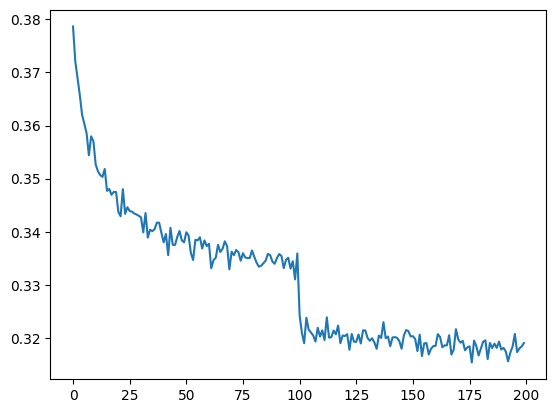

In [29]:
plt.plot(torch.tensor(lossi).view((-1, 1000)).mean(1))

**Creating layers for embedding and flattening methods:**

Notice how the embedding and flattening (emb.view) operations are outside of the layers - we should create layers for those too. In addition, PyTorch has methods to create lists, dictionaries, or other data types out of layers; the one to create a list is called Sequential, which we'll also implement.

In [68]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
     return [p for layer in self.layers for p in layer.parameters()]
        

In [69]:
n_embd = 10 # dimentionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# removed the C = torch.randn() and layers definition
model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])
with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters() # removed the [C] + [p for ...]
print(sum(p.nelement() for p in parameters)) # of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [70]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  # x = Xb # removed the embedding steps
  # for layer in layers:
  #   x = layer(x)
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.2798
  10000/ 200000: 2.4363
  20000/ 200000: 2.2806
  30000/ 200000: 2.4507
  40000/ 200000: 2.3296
  50000/ 200000: 2.2583
  60000/ 200000: 2.3216
  70000/ 200000: 2.0487
  80000/ 200000: 2.3932
  90000/ 200000: 2.3266
 100000/ 200000: 2.5826
 110000/ 200000: 1.8778
 120000/ 200000: 2.2689
 130000/ 200000: 2.4382
 140000/ 200000: 2.2319
 150000/ 200000: 2.4896
 160000/ 200000: 2.5729
 170000/ 200000: 2.1977
 180000/ 200000: 2.1830
 190000/ 200000: 1.9904


In [71]:
for layer in model.layers:
    layer.training = False

In [72]:
@torch.no_grad() # this decorator disables gradient tracking

def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0660974979400635
val 2.111114025115967


In [73]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

raylee.
eveomarhithi.
danakinn.
dayanleighleea.
marzely.
fatykody.
akeen.
gavliigatlyn.
lyn.
laan.
rayiah.
azlarittie.
aymougiuss.
jail.
yuline.
magani.
amareeth.
healaat.
zamira.
bharmanra.


### 
WaveNet Implementation

Since the train loss and validation loss are fairly similar, we can see that we are not overfitting and that we can safely expand the network to make it larger and deeper. 

One way we could do this is by adding more hidden layers, but that wont fix the biggest bottleneck right now, which is squashing all of the inputs in a single layer. It would be better if we could slowly fuse the inputs into an embedding rather than squashing them all in one layer. 

A good implementation of this is the WaveNet model:
![title](wavenet.png)

Notice how it slowly squashes the characters into bigrams, then bigrams into quadgrams, followed by quadgrams into octograms, etc.

First thing we can change is the blocksize:

In [74]:
# build the dataset
block_size = 8 # change context length to 8 

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [75]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [79]:
n_embd = 10 # dimentionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# removed the C = torch.randn() and layers definition
model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])
with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.paarameters() # removed the [C] + [p for ...]
print(sum(p.nelement() for p in parameters)) # of parameters in total
for p in parameters:
    p.requires_grad = True

22097


In [80]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  # x = Xb # removed the embedding steps
  # for layer in layers:
  #   x = layer(x)
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.6211
  10000/ 200000: 2.4444
  20000/ 200000: 2.3995
  30000/ 200000: 1.8001
  40000/ 200000: 2.0889
  50000/ 200000: 2.1323
  60000/ 200000: 2.4618
  70000/ 200000: 2.0345
  80000/ 200000: 1.6695
  90000/ 200000: 2.0854
 100000/ 200000: 1.9911
 110000/ 200000: 1.8938
 120000/ 200000: 1.8093
 130000/ 200000: 2.0852
 140000/ 200000: 1.8769
 150000/ 200000: 2.1835
 160000/ 200000: 1.7586
 170000/ 200000: 2.0277
 180000/ 200000: 1.6878
 190000/ 200000: 2.2097


In [81]:
@torch.no_grad() # this decorator disables gradient tracking

def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9257512092590332
val 2.0314769744873047


Notice how the train and val losses already improved a noticeable amount just by increase the context length. However, we're still crushing too much data too quickly. Regardless, this is still a good rough baseline to compare with the WaveNet implementation.

Changing Layer Dimensions:

In [83]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  3,  1, 12,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  9],
        [ 0,  0,  0,  0,  0,  0, 13, 15],
        [ 0,  0,  0,  0,  0,  0,  0,  1]])

In [84]:
model.layers[0].out.shape # output of embedding layer

torch.Size([4, 8, 10])

In [85]:
model.layers[1].out.shape # output of flatten layer

torch.Size([4, 80])

In [86]:
model.layers[2].out.shape # output of linear layer

torch.Size([4, 200])

In [90]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

Matmul in pytorch allows us to have an n number of dimensions , as it only multiplies the last dimension as seen below:

In [89]:
(torch.randn(4, 5, 6, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 6, 200])

What we want to do now is to group evvery 2 characters and pass them in together as such:

(1 2) (3 4) (5 6) (7 8)

Therefore, we want to change adjust our matmul as such:

(4, 80) --> (4, 4, 20) we're changing the 8 individual characters to groups of 2 characters

(80, 200) --> (20, 200) since we want 2 characters at a time and to match the last dimension of the prev layer

We also want to adjust the flatten layer to return (4, 4, 20):



In [ ]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []


### Final Implementation

In [114]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [115]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [116]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.2768
  10000/ 200000: 1.9790
  20000/ 200000: 2.0037
  30000/ 200000: 2.0101
  40000/ 200000: 2.0484
  50000/ 200000: 2.5808
  60000/ 200000: 2.1166
  70000/ 200000: 2.1996
  80000/ 200000: 2.4853
  90000/ 200000: 1.8417
 100000/ 200000: 1.7765
 110000/ 200000: 2.1086
 120000/ 200000: 1.9688
 130000/ 200000: 1.7744
 140000/ 200000: 2.3335
 150000/ 200000: 1.9149
 160000/ 200000: 1.5684
 170000/ 200000: 2.0051
 180000/ 200000: 1.8906
 190000/ 200000: 1.8431


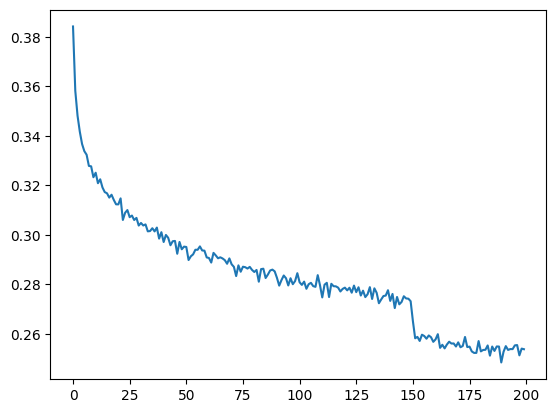

In [117]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [118]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [119]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7663874626159668
val 1.9856926202774048


### Performance Log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


In [120]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

jlessy.
rayland.
emilyssi.
kjtan.
kamira.
rosialee.
yuwon.
allima.
benja.
maiz.
marks.
samron.
maeveona.
mahari.
rinclaina.
aalyn.
dhya.
bradyn.
laelie.
lilliana.
